## Reading in data available through Maize GDB (Maize Genetics and Genomics Database)
The purpose of this notebook is to read in and do a preliminary analysis of the data related to text descriptions that are available through Maize GDB. The data was provided in the form of the input file by a request through Maize GDB curators, rather than obtained through an already available file from the database. The data needs to be organized and also restructured into a standard format that will allow it to be easily combined with datasets from other resources.

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
import os
import warnings
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

sys.path.append("../../oats")
from oats.utils.constants import NCBI_TAG, UNIPROT_TAG
from oats.utils.constants import EVIDENCE_CODES
from oats.utils.utils import to_abbreviation
from oats.nlp.preprocess import concatenate_with_bar_delim
from oats.nlp.preprocess import other_delim_to_bar_delim
from oats.nlp.preprocess import remove_punctuation
from oats.nlp.preprocess import remove_enclosing_brackets
from oats.nlp.preprocess import concatenate_descriptions
from oats.nlp.preprocess import add_prefix

OUTPUT_DIR = "../data/reshaped_files"
mpl.rcParams["figure.dpi"] = 200
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Part 1: Phenotypic Text Data
Note that fillna is being used here to replace missing values with an empty string. This is done so that the missing string will be quantified when checking for the number of occurences of unique values from different columns, see the analysis below. However this is not necessary as a preprocessing step because when the data is read in and appended to a dataset object later, any missing values or empty strings will be handled at that step.

In [10]:
filename = "../data/gene_related_files/maizegdb/pheno_genes.txt"
usecols = ["phenotype_name", "phenotype_description", "locus_name", "alleles", "locus_synonyms", "v3_gene_model", "v4_gene_model", "uniprot_id", "ncbi_gene"]
df = pd.read_table(filename, usecols=usecols)
df.fillna("", inplace=True)
print(df[["phenotype_name","phenotype_description"]].head(10))
print(df.shape)

        phenotype_name                              phenotype_description
0     2-seeded kernels                                                   
1   A1 null transcript  No color in the aleurone, specifically no colo...
2    aberrant seedling  first leaf is small, round and flat; second le...
3    aberrant seedling  first leaf is small, round and flat; second le...
4  abnormal root hairs                        root hairs fail to elongate
5  abnormal root hairs                        root hairs fail to elongate
6  abnormal root hairs                        root hairs fail to elongate
7  abnormal root hairs                        root hairs fail to elongate
8  abnormal root hairs                        root hairs fail to elongate
9  abnormal root hairs                        root hairs fail to elongate
(3616, 9)


Text information about the phenotypes are contained in both the phenotype name and phenotype description for these data. The can be concatenated and retained together in a new description column that contains all this information, or just the phenotype description could be retained, depending on which data should be used downstream for making similarity comparisons. This is different than for most of the other sources of text used. The next cell looks at how many unique values there are in this data for each column.

In [11]:
# Finding out how many unique values there are for each column.
unique_values = {col:len(pd.unique(df[col].values)) for col in df.columns}
for k,v in unique_values.items():
    print("{:24}{:8}".format(k,v))

phenotype_name               648
phenotype_description        379
locus_name                  1410
alleles                     2088
locus_synonyms              1408
v3_gene_model                482
v4_gene_model                469
uniprot_id                   140
ncbi_gene                    503


There are a fairly small number of distinct phenotype descriptions (379) compared to the number of lines that are in the complete dataset (3,616). This means that the same descriptions is occuring many times. Look at which descriptions are occuring most often.

In [12]:
# Get a list sorted by number of occurences for each phenotype description.
description_counts = df["phenotype_description"].value_counts().to_dict()
sorted_tuples = sorted(description_counts.items(), key = lambda x: x[1], reverse=True)
for t in sorted_tuples[0:10]:
    print("{:6}    {:20}".format(t[1],t[0][:70]))

   892                        
    90    Anthers shriveled, not usually exerted from glum. Pollen absent or abo
    87    seedling white, yellow or palegreen, becomes green, often normal
    81    Seedling leaves are white.
    81    Two classes of albino seedlings: Class I characterized by white or pal
    77    endosperm is opaque and firm, not chalky and not waxy
    73    small kernel is the consistent characteristic but variable in other as
    73    a general term describing an improperly developed endosperm that appea
    71    endosperm has a soft, chalk-like texture, usually a reduced yellow col
    65    lighter green seedlings or plants; less yellow than yellow green


The only description that occurs far more often than the next is an empty string, where this information is missing entirely. The next cell looks at how many phrases are included in the phenotype description values. Most have a single phrase, some have multiple. These look like they are separated with semicolons.

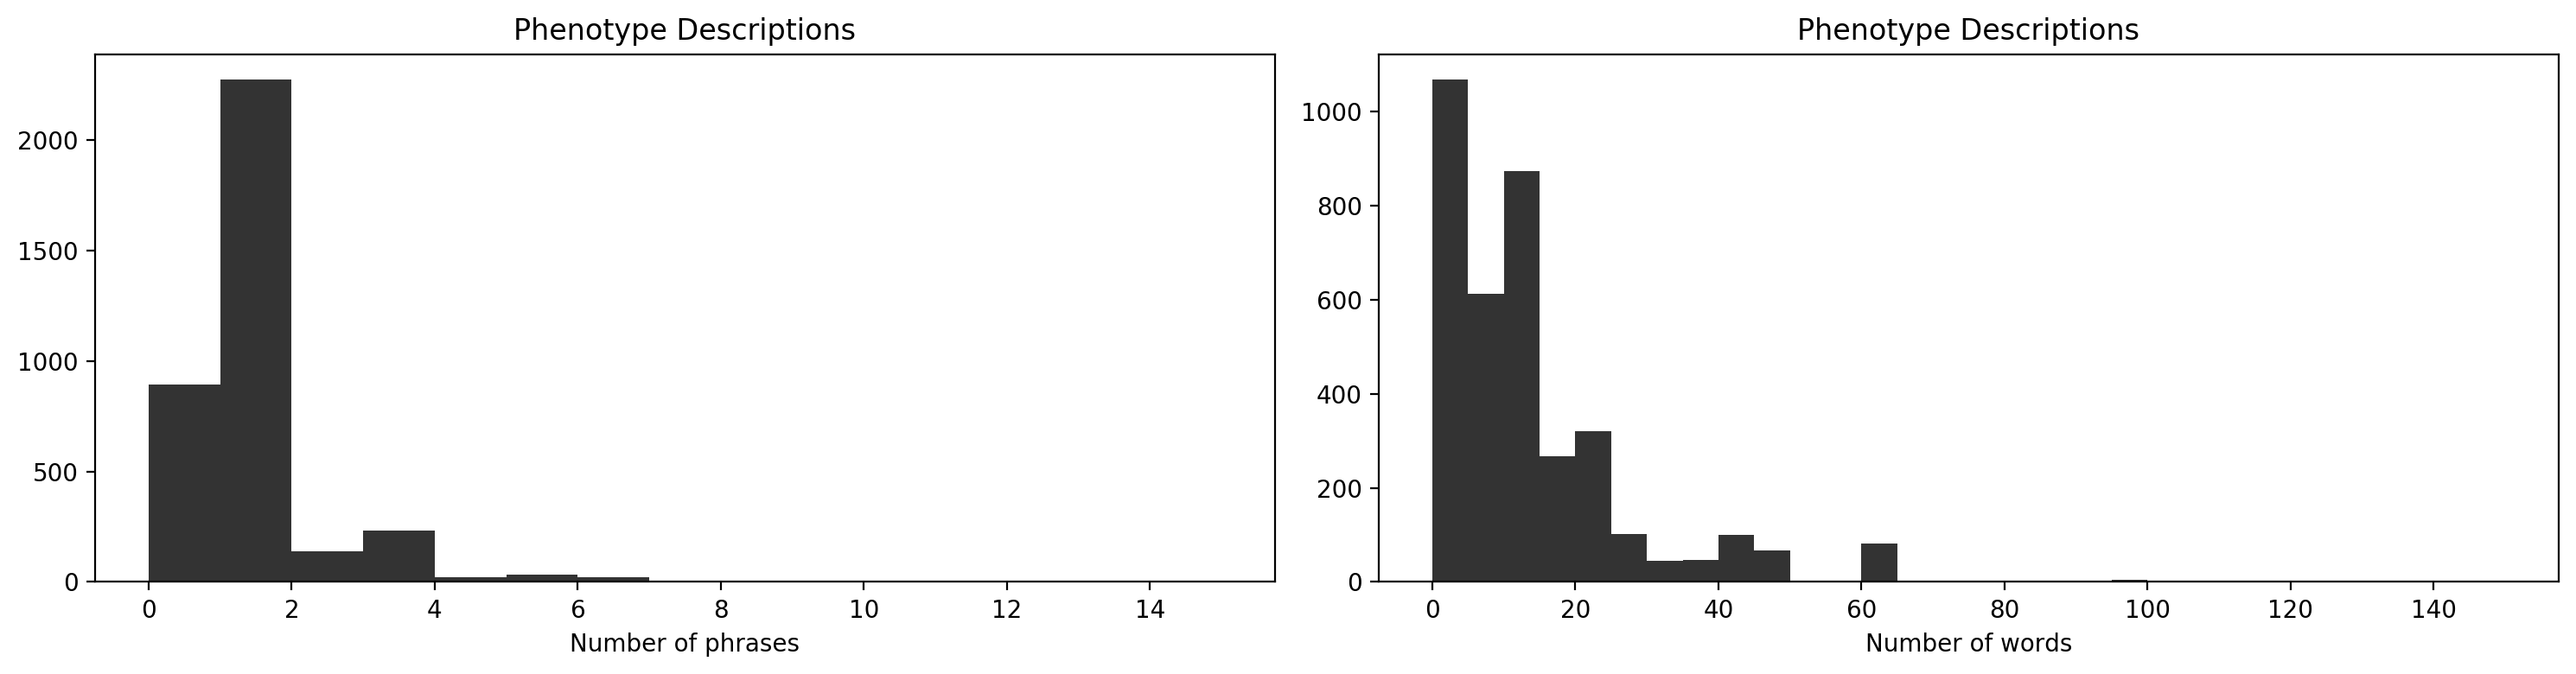

In [13]:
# Plotting distributions of number of phrases in each description.
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Phenotype Descriptions")
ax2.set_title("Phenotype Descriptions")
ax1.set_xlabel("Number of phrases")
ax2.set_xlabel("Number of words")
x1 = [len(sent_tokenize(x)) for x in df["phenotype_description"].values]
x2 = [len(word_tokenize(x)) for x in df["phenotype_description"].values]
ax1.hist(x1, bins=15, range=(0,15), density=False, alpha=0.8, histtype='stepfilled', color="black", edgecolor='none')
ax2.hist(x2, bins=30, range=(0,150), density=False, alpha=0.8, histtype='stepfilled', color="black", edgecolor='none')
fig.set_size_inches(15,4)
fig.tight_layout()
fig.show()

In [14]:
# Restructuring the dataset to include all the expected column names.
df["description"] = np.vectorize(concatenate_descriptions)(df["phenotype_name"], df["phenotype_description"])
df["uniprot_id"] = df["uniprot_id"].apply(add_prefix, prefix=UNIPROT_TAG)
df["ncbi_gene"] = df["ncbi_gene"].apply(add_prefix, prefix=NCBI_TAG)
df["gene_names"] = np.vectorize(concatenate_with_bar_delim)(df["locus_name"], df["alleles"], df["locus_synonyms"], df["v3_gene_model"], df["v4_gene_model"], df["uniprot_id"], df["ncbi_gene"])
df["species"] = "zma"
df["term_ids"] = ""
df["pmid"] = ""
df = df[["species", "gene_names", "description", "term_ids", "pmid"]]
print(df[["species","gene_names"]].head(10))
print(df[["species","gene_names"]].sample(10))

  species                                         gene_names
0     zma              wcr1|Wcr1-reference|wandering carpel1
1     zma  a1|a1-m2-8004::dSpm|anthocyaninless1|bnl(a1)|D...
2     zma  pve1|pve1-M2|pve1-R|AC211276.4_FG008|cl12053_1...
3     zma  ubl1|ubl1-1|si945031h05(438)|si945031h05a|GRMZ...
4     zma  bhlh10|bhlh10-1|bhlh10-2|Lotus japonicus rooth...
5     zma  rboh1|rth5-1|rth5-2|rth5-3|rth5-4|pco107390|pc...
6     zma  rth1|rth1-1|rth1-2d|exocyst complex component ...
7     zma                           rth2|roothair defective2
8     zma  rth3|rth3-3|AY112035|roothair defective3|GRMZM...
9     zma  rth6|rth6-1|rth6-2|rth6-3|rth6-4|rth6-5|rth6-6...
     species                                         gene_names
102      zma  w18|w18-N495A|w18-N571C|w*-495A|w*-571C|white1...
1124     zma                 emp8|emp8-8075|emp8-8300|emp8-8971
3070     zma                 v33|v*-N1387B|v*-1387B|virescent33
2232     zma  spt2|spt2-N1269A|spt2-N1339B|pgspt*-1269A|spot...
634      

In [15]:
# Outputting the dataset of descriptions to a csv file.
path = os.path.join(OUTPUT_DIR,"zma_phenotypes.csv")
df.to_csv(path, index=False)